## Phase Dispersion Minimization

The [PDM](https://ui.adsabs.harvard.edu/abs/1978ApJ...224..953S/abstract) is well suited to the case of nonsinusoidal time variation covered by only a few irregularly spaced observations.

Given the magnitudes $\mathbf{x}$ and the observation times $\mathbf{t}$, the variance of $\mathbf{x}$
$$
\sigma = \frac{\sum(x_i - \bar{x})^2}{N-1}
$$
where $\bar{x}$ is the mean and N is the number or data points.

For any subset of the sample, the variance $s^2$ is exactly as in the previous equation. Suppose we have chosen M distinct subsets, having variance $s_j^2 (j=1,...,M)$ and containg $n_j$ data points, the overall variance is then given by

$$
s^2 = \frac{\sum(n_j - 1)s_j^2}{\sum n_j-M}.
$$

The full phase interval (0, 1) is divided into fixed bins. PDM method minimize the variance of the data with respect to the mean light curve in phase space. For a given trial period P, the phase vector
$$
\Phi_i = t_i/P - [t_i/P].
$$

The variance of these samples gives a measure of the scatter around the mean light curve, where the mean is defined for each bin as a function of $\Phi$. The PDM statistics is defined as
$$
\Theta = \frac{s^2}{\sigma^2}.
$$

If P is not a true period, then $s^2 \approx \sigma^2$  and $\theta \approx 1$, whereas if P is a correct period, $\theta$ will reach a local minimum compared with neighboring periods, hopefully near zero. Thus, we wish to minimize $\theta$.

The cuvarbase PDM implementation calculates the value of $1 - \Theta$, thus __best period can be found by maximizing the statistics__.

The original PDM technique has been updated [(PDM2)](http://www.stellingwerf.com/rfs-bin/index.cgi?action=PageView&id=29) to solve some issues. The bin variance calculation is equivalent to a curve fit with step functions across each bin, which can introduce errors in the result if the underlying curve is non-symmetric. This can be eliminated by replacing the step function by a linear fit drawn between bin means.

The following phase curve shows an example of calculating the bin means in PDM (left) and PDM2 (right) for each data point.

![PDM_bin](PDM_bin.jpg)
![PDM2_bin](PDM2_bin.jpg)

[Plavchan (2008)](https://ui.adsabs.harvard.edu/abs/2014ApJS..211....3P/abstract) introduced a binless version of the PDM algorithm (Plavchan algorithm). The binned PDM approach is susceptible to period aliases when the cadence is semi-regular (e.g. nightly observations). Plavchan and colleagues avoided this aliasing by computing a boxcar smoothed phased time-series, where the box-car width can be thought of as the old bin size.

For each trial period, $P_j$, the method starts by generating a phase-folded light curve from the time-series photometry. This light curve is smoothed via boxcar smoothing with a phase width, $p$. This smoothed light curve is designated as the prior or reference curve. The difference between the measured photometry and the prior is computed for every photometric measurement, $m_i$. A quality of fit, $\chi^2$, is computed by
$$
\chi^2 = \frac{\sum_i(m_i-\bar{m})^2}{\sum_i(m_i-m_{prior,i})^2},
$$
where the prior term, $m_{prior,i}$, is the mean of $m_i$ if $m_i$ is within the boxcar smoothing window. The best-fits periods have the largest $\chi^2$ value.

To even supress the alising, a Gaussian window smooting can be applied instead of a boxcar window.

The following phase curve shows an example of calculating the mean light curve using a boxcar (left) and a Gaussian (right) window.

![PDM_tophat](PDM2_binless_tophat.jpg)
![PDM_gauss](PDM2_binless_gauss.jpg)

## Using `PDMAsyncProcess`

/home/jupyter-abodi/GitHub/cuvarbase/cuvarbase/pdm.py:152: UserWarning: PDM is experimental at this point. Use with great caution.
  warnings.warn("PDM is experimental at this point. "


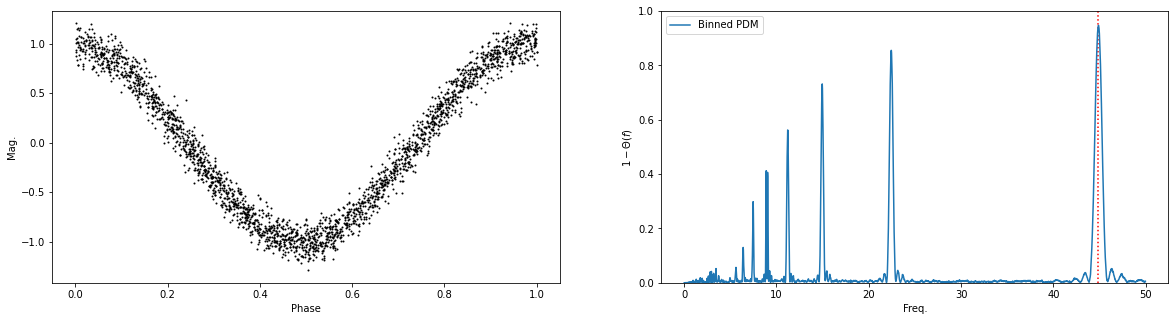

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cuvarbase.pdm import PDMAsyncProcess
from cuvarbase.utils import weights, autofrequency

def data(seed=100, sigma=0.1, ndata=250, f=10):

    rand = np.random.RandomState(seed)

    t = np.sort(rand.rand(ndata))
    y = np.cos(2 * np.pi * (f/(max(t) - min(t))) * t)

    y += sigma * rand.randn(len(t))

    err = sigma * np.ones_like(y)

    return t, y, err

seed = 100
maxfreq = 50
ndata = 2500
f0 = 44.856
sigma = 0.1

# Generate synthetics data
t, y, err = data(seed=seed, ndata=ndata, f=f0, sigma=sigma)

# Calculate weights from observational errors
w = weights(err)

# Generate frequency grid
freqs = autofrequency(t,nyquist_factor=1,
    samples_per_peak=50,
    minimum_frequency=0,
    maximum_frequency=maxfreq)

# Select PDM and set corresponding parameter
kind = 'binned_step'
nbins = 10

# Initialize process
pdm_proc = PDMAsyncProcess()

# Run PDM
results = pdm_proc.run([(t, y, w, freqs)], kind=kind, nbins=nbins)

# Finish process
pdm_proc.finish()

# Parse the results
pow_gpu = results[0]

# Plot
f, (axlc, axlsp) = plt.subplots(1, 2, figsize=(20, 5))
axlc.scatter((t * f0) % 1.0, y, c='k', s=1)
axlc.set_xlabel('Phase')
axlc.set_ylabel('Mag.')

axlsp.plot(freqs, pow_gpu, alpha=1, label='Binned PDM')
axlsp.axvline(f0, ls=':', color='r',zorder=0)
axlsp.set_xlabel('Freq.')
axlsp.set_ylabel('$1-\Theta(f)$')
axlsp.set_ylim(0,1)
axlsp.legend(loc='best')
plt.show()

### Other kind of PDM methods can be run similarly 

/home/jupyter-abodi/GitHub/cuvarbase/cuvarbase/pdm.py:152: UserWarning: PDM is experimental at this point. Use with great caution.
  warnings.warn("PDM is experimental at this point. "


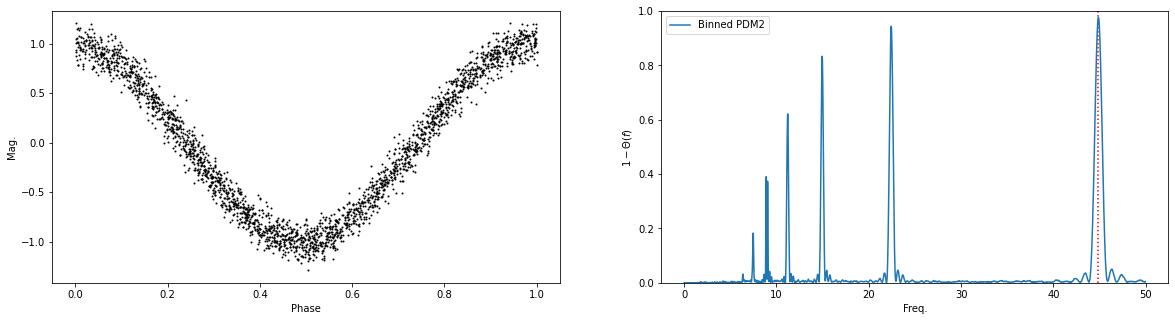

/home/jupyter-abodi/GitHub/cuvarbase/cuvarbase/pdm.py:152: UserWarning: PDM is experimental at this point. Use with great caution.
  warnings.warn("PDM is experimental at this point. "


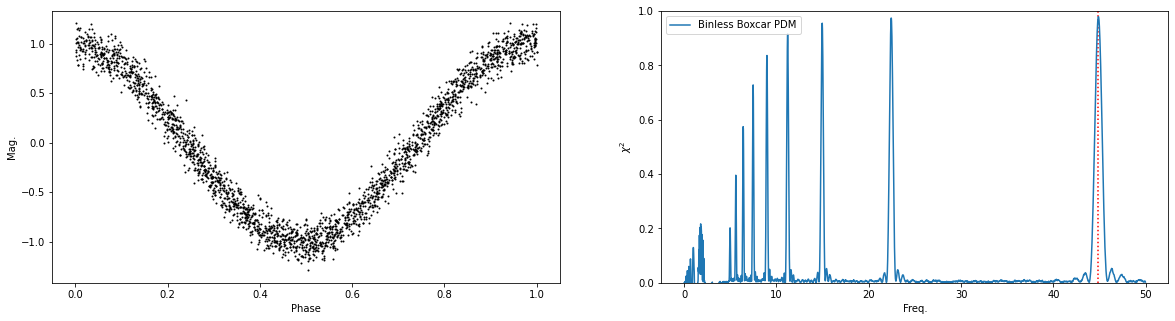

/home/jupyter-abodi/GitHub/cuvarbase/cuvarbase/pdm.py:152: UserWarning: PDM is experimental at this point. Use with great caution.
  warnings.warn("PDM is experimental at this point. "


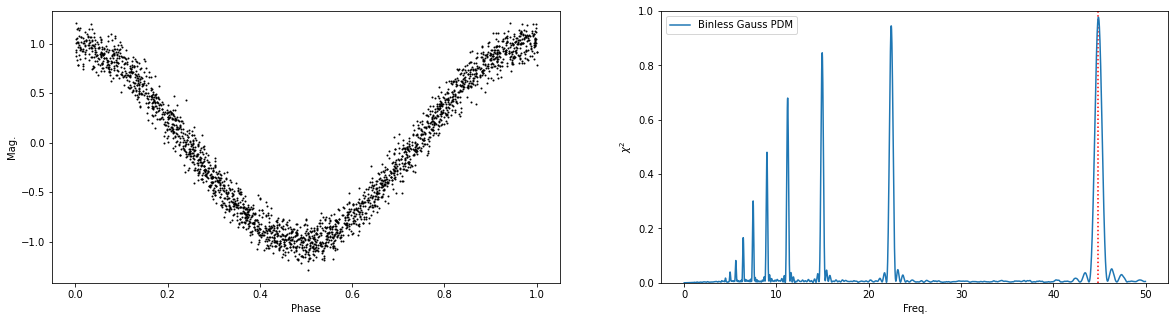

In [2]:
# -------------------- PDM2 --------------------
# Select PDM and set corresponding parameter
kind = 'binned_linterp'
nbins = 10

# Initialize process
pdm_proc = PDMAsyncProcess()

# Run PDM
results = pdm_proc.run([(t, y, w, freqs)], kind=kind, nbins=nbins)

# Finish process
pdm_proc.finish()

# Parse the results
pow_gpu = results[0]

# Plot
f, (axlc, axlsp) = plt.subplots(1, 2, figsize=(20, 5))
axlc.scatter((t * f0) % 1.0, y, c='k', s=1)
axlc.set_xlabel('Phase')
axlc.set_ylabel('Mag.')

axlsp.plot(freqs, pow_gpu, alpha=1, label='Binned PDM2')
axlsp.axvline(f0, ls=':', color='r',zorder=0)
axlsp.set_xlabel('Freq.')
axlsp.set_ylabel('$1-\Theta(f)$')
axlsp.set_ylim(0,1)
axlsp.legend(loc='best')
plt.show()

# -------------------- Binless Boxcar --------------------
# Select PDM and set corresponding parameter
kind = 'binless_tophat'
dphi = 0.05

# Initialize process
pdm_proc = PDMAsyncProcess()

# Run PDM
results = pdm_proc.run([(t, y, w, freqs)], kind=kind, dphi=dphi)

# Finish process
pdm_proc.finish()

# Parse the results
pow_gpu = results[0]

# Plot
f, (axlc, axlsp) = plt.subplots(1, 2, figsize=(20, 5))
axlc.scatter((t * f0) % 1.0, y, c='k', s=1)
axlc.set_xlabel('Phase')
axlc.set_ylabel('Mag.')

axlsp.plot(freqs, pow_gpu, alpha=1, label='Binless Boxcar PDM')
axlsp.axvline(f0, ls=':', color='r',zorder=0)
axlsp.set_xlabel('Freq.')
axlsp.set_ylabel('$\chi^2$')
axlsp.set_ylim(0,1)
axlsp.legend(loc='best')
plt.show()

# -------------------- Binless Gauss --------------------
# Select PDM and set corresponding parameter
kind = 'binless_gauss'
dphi = 0.05

# Initialize process
pdm_proc = PDMAsyncProcess()

# Run PDM
results = pdm_proc.run([(t, y, w, freqs)], kind=kind, dphi=dphi)

# Finish process
pdm_proc.finish()

# Parse the results
pow_gpu = results[0]

# Plot
f, (axlc, axlsp) = plt.subplots(1, 2, figsize=(20, 5))
axlc.scatter((t * f0) % 1.0, y, c='k', s=1)
axlc.set_xlabel('Phase')
axlc.set_ylabel('Mag.')

axlsp.plot(freqs, pow_gpu, alpha=1, label='Binless Gauss PDM')
axlsp.axvline(f0, ls=':', color='r',zorder=0)
axlsp.set_xlabel('Freq.')
axlsp.set_ylabel('$\chi^2$')
axlsp.set_ylim(0,1)
axlsp.legend(loc='best')
plt.show()